<h1 style="text-align:center;">Enhancing Brain Tumor Diagnosis with MRI and Neural Networks</h1>

## Introduction

A brain tumor is an abnormal growth of cells within the brain or the central spinal canal. These tumors can be either benign (non-cancerous) or malignant (cancerous), and they can originate in the brain itself (primary brain tumors) or spread from other parts of the body. Common types of brain tumors include gliomas, meningiomas, and pituitary tumors, each varying in behavior, growth rate, and response to treatment.

The timely and accurate detection of brain tumors is crucial for effective treatment and improved patient outcomes. This notebook aims to demonstrate the application of advanced deep learning techniques to enhance the diagnosis of brain tumors using MRI scans. By leveraging neural networks, we strive to provide a reliable and efficient tool for the medical community that can assist in the early detection and precise localization of tumors.

For hospitals and doctors, this approach promises several significant benefits. Enhanced diagnostic accuracy reduces the likelihood of missed diagnoses and improves the accuracy of tumor detection. Increased efficiency automates the analysis process, allowing radiologists and doctors to focus more on patient care rather than time-consuming image reviews. Early intervention facilitated by this technology enables earlier detection of tumors, leading to timely and targeted treatment interventions which can significantly improve patient outcomes. Furthermore, resource optimization frees up valuable medical resources by streamlining the diagnostic workflow.


In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
import os
import random

In [6]:
# General plot parameters
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams.update({'font.size': 15})

In [7]:
# Paths and labels
path_train = r"C:\Users\crloc\OneDrive\Documents\SpringBoard\GitHub\SpringBoard\Notebooks\Final Capstone\Complied MRI Images\Training"
path_test = r"C:\Users\crloc\OneDrive\Documents\SpringBoard\GitHub\SpringBoard\Notebooks\Final Capstone\Complied MRI Images\Testing"
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 168

In [8]:
# Count number of images per class
def count_images(directory):
    return {dir: len(os.listdir(os.path.join(directory, dir))) for dir in os.listdir(directory)}

number_of_images_train = count_images(path_train)
number_of_images_test = count_images(path_test)

print("Training examples: ", number_of_images_train.items())
print("Testing examples: ", number_of_images_test.items())

Training examples:  dict_items([('glioma', 1321), ('meningioma', 1339), ('notumor', 1595), ('pituitary', 1457)])
Testing examples:  dict_items([('glioma', 300), ('meningioma', 306), ('notumor', 405), ('pituitary', 300)])


In [10]:
# Function to load images from directory
def load_images_from_directory(directory, labels, image_size):
    X_data = []
    Y_data = []
    for label in labels:
        folderPath = os.path.join(directory, label)
        for filename in os.listdir(folderPath):
            img = cv2.imread(os.path.join(folderPath, filename))
            img = cv2.resize(img, (image_size, image_size))
            X_data.append(img)
            Y_data.append(label)
    return X_data, Y_data

# Load training and testing data
number_of_images_train = count_images(path_train)
number_of_images_test = count_images(path_test)
print("Training examples: ", number_of_images_train.items())
print("Testing examples: ", number_of_images_test.items())

X_data_train, Y_data_train = load_images_from_directory(path_train, labels, image_size)
X_data_test, Y_data_test = load_images_from_directory(path_test, labels, image_size)

# Combine train and test data for EDA purposes
X_data = X_data_train + X_data_test
Y_data = Y_data_train + Y_data_test

Training examples:  dict_items([('glioma', 1321), ('meningioma', 1339), ('notumor', 1595), ('pituitary', 1457)])
Testing examples:  dict_items([('glioma', 300), ('meningioma', 306), ('notumor', 405), ('pituitary', 300)])


The dataset for this brain tumor detection project consists of MRI images categorized into four distinct classes: glioma, meningioma, no tumor, and pituitary tumor. The dataset is divided into training and testing sets to facilitate model development and evaluation.

No that we have loaded in our data we will explore some of the data.

## Exploratory Data Analysis

Overall mean pixel value: 47.55
Overall standard deviation of pixel values: 46.98


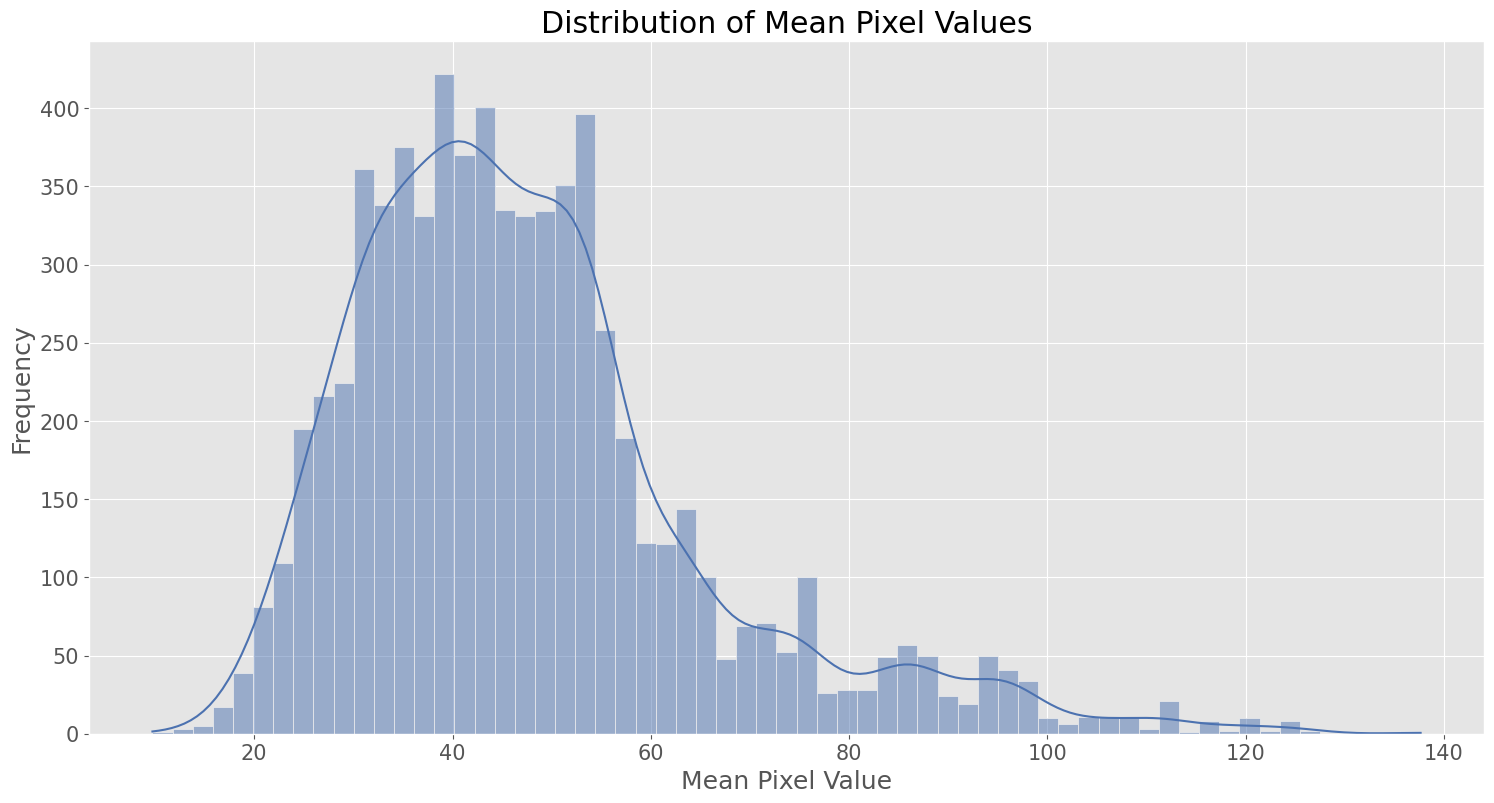

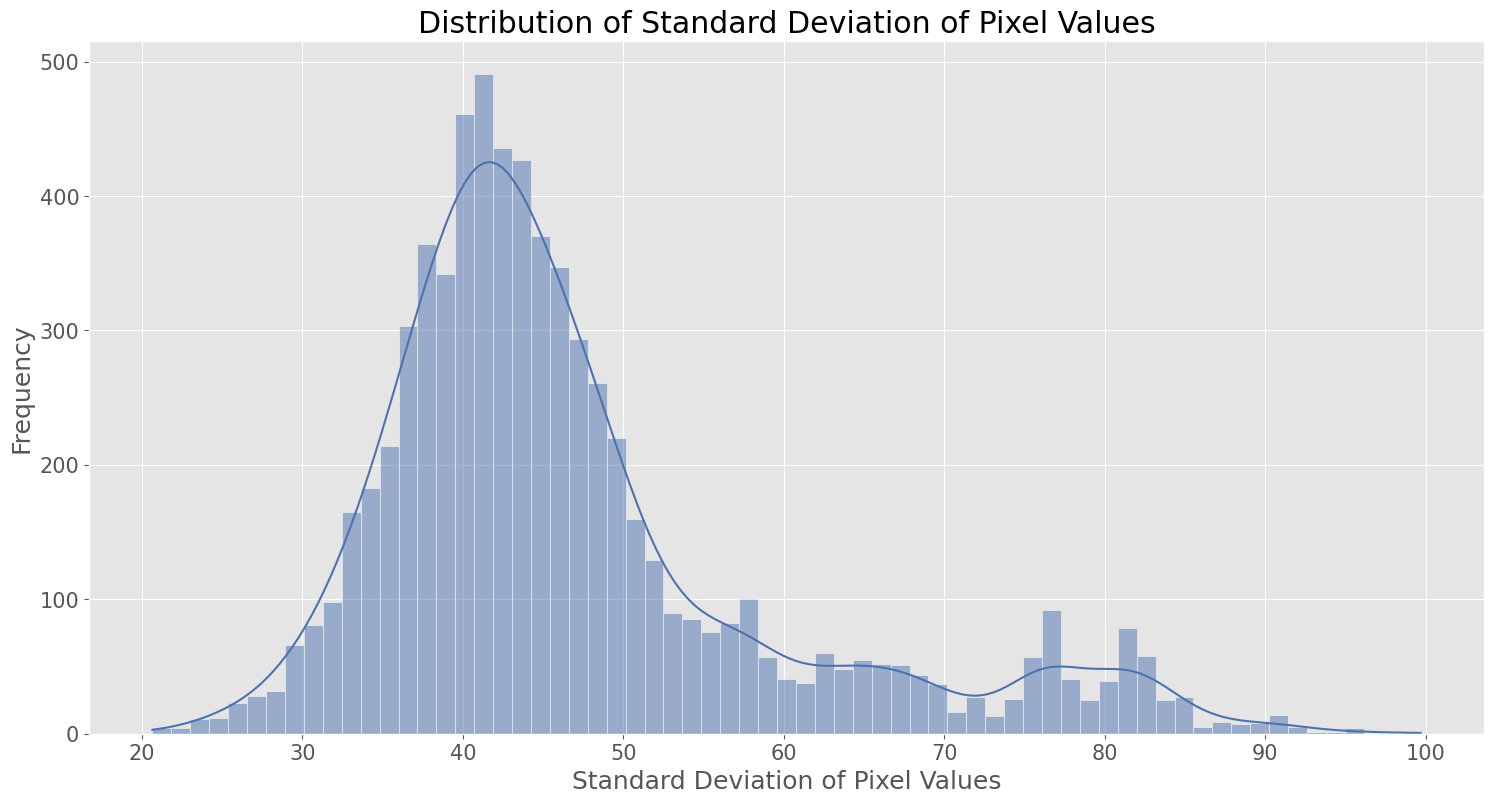

In [11]:
# EDA functions
def analyze_images(X_data):
    X_data_np = np.array(X_data)
    means = X_data_np.mean(axis=(1, 2, 3))
    stds = X_data_np.std(axis=(1, 2, 3))
    
    print(f"Overall mean pixel value: {means.mean():.2f}")
    print(f"Overall standard deviation of pixel values: {stds.mean():.2f}")
    
    # Histogram for mean pixel values
    sns.histplot(means, kde=True, color='#4C72B0')
    plt.title('Distribution of Mean Pixel Values')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Histogram for standard deviation of pixel values
    sns.histplot(stds, kde=True, color='#4C72B0')
    plt.title('Distribution of Standard Deviation of Pixel Values')
    plt.xlabel('Standard Deviation of Pixel Values')
    plt.ylabel('Frequency')
    plt.show()

analyze_images(X_data)

The histograms above illustrate the distribution of mean pixel values and the standard deviation of pixel values across the MRI images in the dataset. The mean pixel value distribution shows a right-skewed shape, with most images having mean pixel values between 20 and 60, and a calculated overall mean of 47.55. This indicates that the majority of the images have relatively low average pixel intensities, likely due to the inherent dark background in MRI scans. 

The distribution of the standard deviation of pixel values, which has an overall mean of 46.98, is also somewhat right-skewed, with most images having standard deviations between 30 and 60. This suggests a moderate level of variation in pixel intensities within the images, reflective of the varied tissue densities and structures within brain MRI scans. 

These distributions imply that the images are generally consistent in their intensity profiles, which is beneficial for training robust deep learning models for tumor detection and classification. The observed skewness towards lower mean pixel values and moderate standard deviations further emphasizes the need for effective normalization and preprocessing steps to enhance model performance.

In [12]:
#Image shape
image_shapes = [img.shape for img in X_data]
unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")

Unique image shapes: {(168, 168, 3)}


The analysis of image shapes within the dataset indicates that all images have a consistent shape of (168, 168, 3), meaning each image is 168 pixels in width, 168 pixels in height, and has three color channels (RGB). This uniformity in image dimensions is crucial for training deep learning models, as neural networks require inputs of the same shape to process the data effectively. 

In [10]:
#detect blurred images
def detect_blur(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

blurred_images = [img for img in X_data if detect_blur(img)]
print(f"Number of blurred images: {len(blurred_images)}")

Number of blurred images: 5


In [14]:
#Remove blurred images
X_data_cleaned = [img for img in X_data if not detect_blur(img)]
Y_data_cleaned = [label for img, label in zip(X_data, Y_data) if not detect_blur(img)]

print(f"Number of images after removing blurred ones: {len(X_data_cleaned)}")

Number of images after removing blurred ones: 7018


The analysis of image quality within the dataset revealed that out of the total images, only 5 were identified as blurred using a Laplacian variance threshold of 100, indicating that the vast majority of images are clear and suitable for training. After removing these blurred images, the dataset now consists of 7,018 images, ensuring high-quality data for model training. This minimal number of blurred images suggests that the dataset is well-prepared and robust, reducing the risk of poor model performance due to low-quality inputs. 

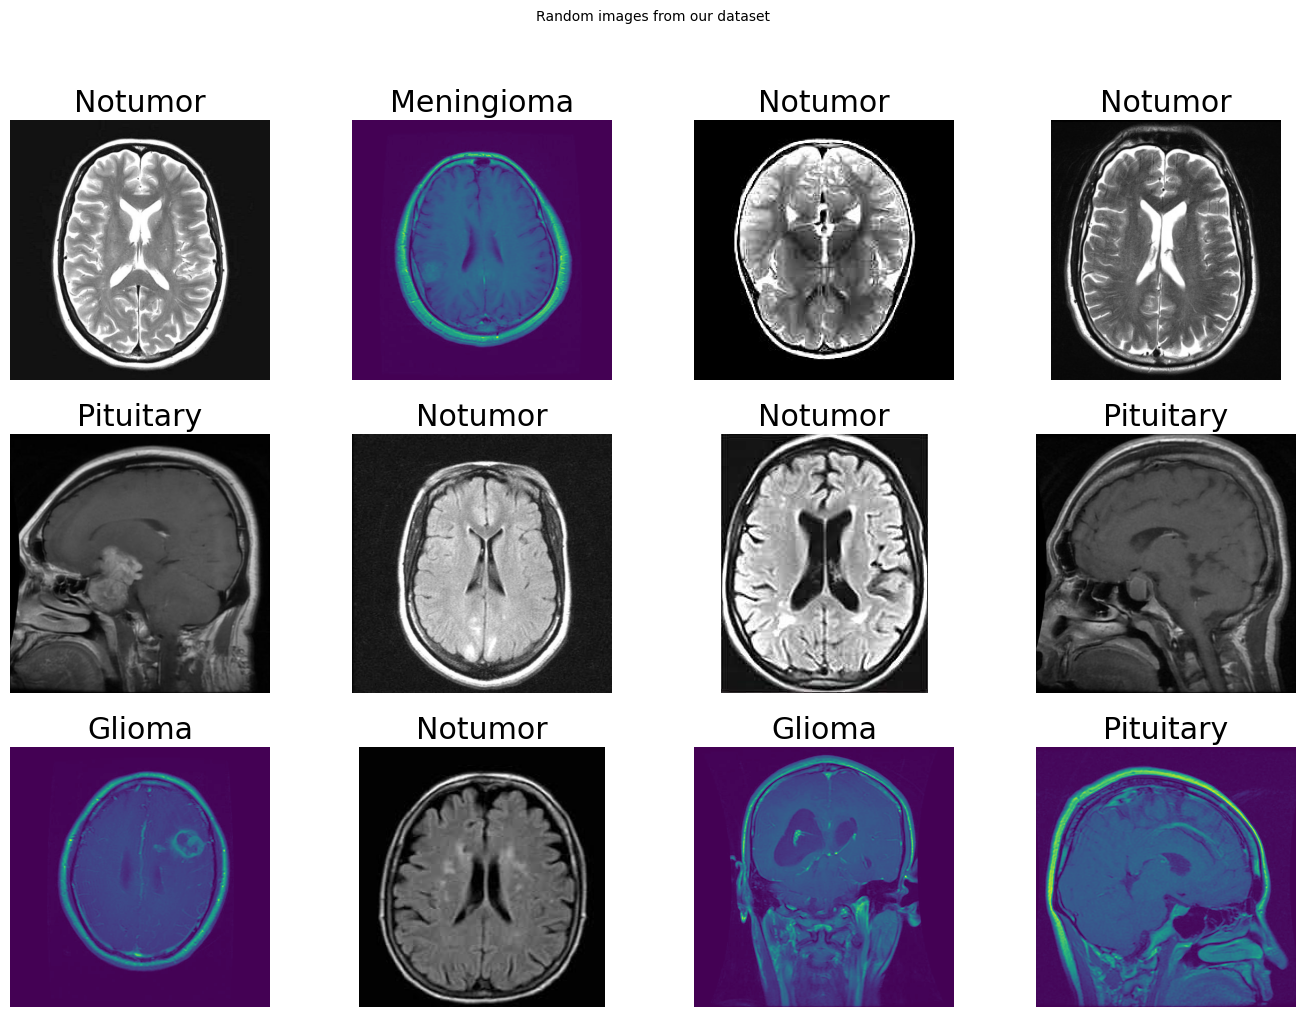

In [13]:
# Visualize random images from the dataset
def visualize_random_images(paths, num_images=12):
    all_image_files = []
    for path in paths:
        image_files = os.listdir(path)
        full_paths = [os.path.join(path, img_file) for img_file in image_files]
        all_image_files.extend(full_paths)
    
    random_images = random.sample(all_image_files, num_images)
    
    plt.figure(figsize=(14, 10))
    plt.suptitle('Random images from our dataset', fontsize=10, y=1.02)
    
    for i, image_file in enumerate(random_images):
        img = mpimg.imread(image_file)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(os.path.dirname(image_file)).capitalize())
    
    plt.tight_layout()
    plt.show()

# Define paths for each label
paths = [os.path.join(path_train, label) for label in labels]
visualize_random_images(paths, num_images=12)

The visualization of random images from the dataset provides a comprehensive overview of the diverse MRI scans available, showcasing different classes such as glioma, meningioma, no tumor, and pituitary tumor. Each image is clearly labeled, indicating its classification and providing insight into the various anatomical views and sections of the brain, including axial, coronal, and sagittal perspectives. This diversity in image types is crucial for training a robust deep learning model that can generalize well across different MRI scans, ensuring it can accurately identify and classify brain tumors regardless of the specific scan type or angle.

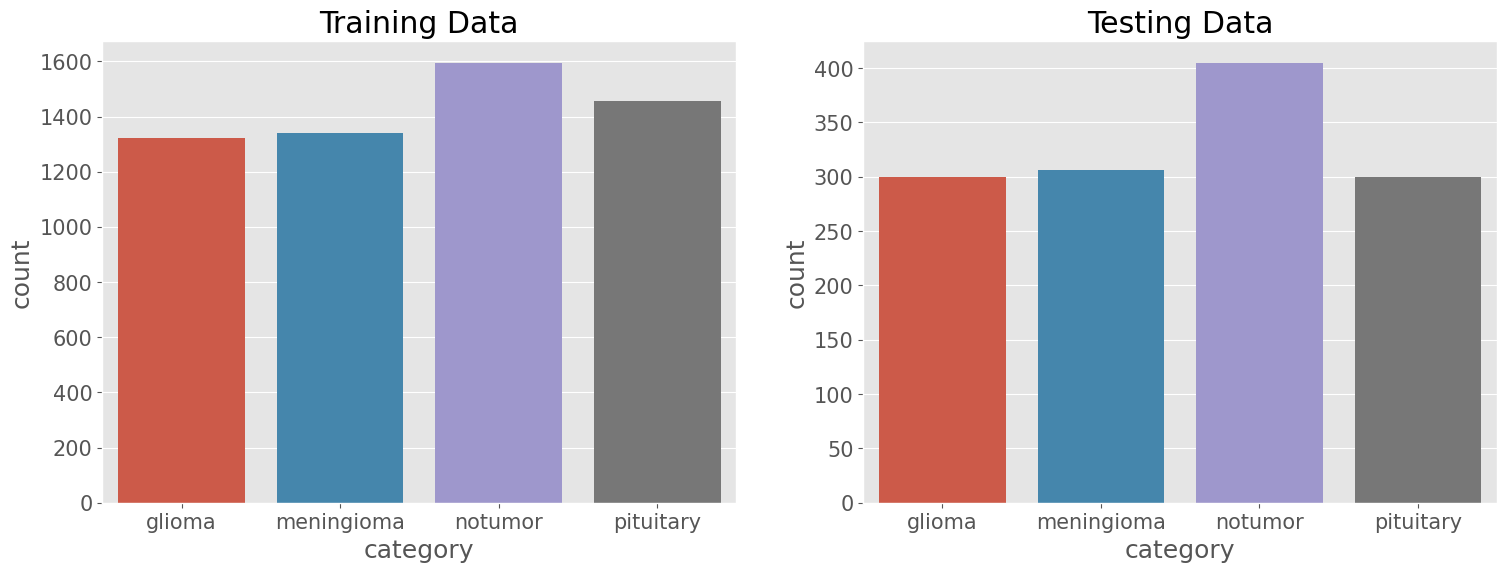

In [15]:
# Bar graph of image counts
def plot_image_counts(train_counts, test_counts):
    train_df = pd.DataFrame.from_dict(train_counts, orient='index', columns=['count']).reset_index()
    train_df = train_df.rename(columns={'index': 'category'})
    test_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['count']).reset_index()
    test_df = test_df.rename(columns={'index': 'category'})
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    sns.barplot(x='category', y='count', data=train_df, ax=axes[0])
    axes[0].set_title('Training Data')
    
    sns.barplot(x='category', y='count', data=test_df, ax=axes[1])
    axes[1].set_title('Testing Data')
    
    plt.show()

plot_image_counts(number_of_images_train, number_of_images_test)


The bar graphs illustrate the distribution of image counts across different categories for both the training and testing datasets. We see a consistent distribution between training and testing sets which will ensure that the model will be trained and evaluated on a balanced dataset, reflecting real-world scenarios and promoting better generalization.

We have thoroughly examined various aspects of our dataset. The high-quality images, balanced class distribution, and diverse perspectives in the MRI scans provide a solid foundation for building a reliable and effective model for brain tumor detection and classification. With the dataset's integrity ensured, we can confidently proceed to the next stages of model training and evaluation.